The task of time series forecasting has successfully been tackled classically using many forms of recurrent neural networks. Our task would here be to construct a quantum recurrent neural network. Let's start with importing the data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

dataframe = pd.read_csv("C:/Users/DELL/Downloads/DJI.csv")
dataset = dataframe['Value']
dataset = np.array(dataset)
dataset = dataset.reshape(-1,1)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset

array([[0.00000000e+00],
       [5.12580698e-04],
       [1.51405649e-03],
       [2.51188835e-03],
       [4.97701282e-03],
       [4.02290823e-03],
       [4.26340818e-03],
       [4.02898146e-03],
       [5.41550010e-03],
       [7.55813600e-03],
       [9.61210273e-03],
       [1.09889042e-02],
       [1.03208488e-02],
       [1.78206818e-02],
       [2.29228032e-02],
       [2.35951098e-02],
       [1.97216031e-02],
       [2.87075557e-02],
       [3.45202451e-02],
       [3.06655654e-02],
       [3.76649641e-02],
       [3.28646823e-02],
       [3.95968589e-02],
       [4.63490772e-02],
       [5.21265418e-02],
       [4.09779117e-02],
       [4.82305641e-02],
       [5.05772606e-02],
       [4.18688546e-02],
       [4.42106925e-02],
       [4.73250454e-02],
       [5.52093139e-02],
       [4.49358363e-02],
       [3.06868217e-02],
       [4.50299714e-02],
       [5.42758583e-02],
       [4.37400171e-02],
       [4.21512599e-02],
       [4.41997607e-02],
       [5.18064826e-02],


The data at a given point of time depends upon the value at previous time steps. Any Quantum Recurrent Neural Network is a three step process. We start with two subsets of qubits $n_B$ and $n_A$. The first subset is used to encode the data. At each time step, the qubits in the subset $n_B$ are encoded with the datum. Lets call the register containing the $n_A$ qubits as the Encoding Register. The qubits in the subset $n_A$ are used to store the memory from the previous time steps. Lets call the register containing the $n_A$ qubits as the memory register. 

Let's begin with defining the Registers and the resulting quantum circuit.

In [2]:
from qiskit import QuantumCircuit, Aer, execute, QuantumRegister, ClassicalRegister

# Defining Encoding and Memory Registers with 1 qubit each since the data at any time has only one value (or only one dimension/feature).
EncodingRegister = QuantumRegister(1, 'encode')

# (We can have multiple qubits in the memory register to acccount for the complexity of the task)
MemoryRegister = QuantumRegister(1, 'memory')

# Putting the Registers together to make a Quantum Circuit.
qc = QuantumCircuit(2)

At time $t$, the Encoding Register has to be fed with the data at the time $t$. This task is performed using a Unitary Operator in a quantum circuit. Let's define an encoding function for the same.

In [3]:
from math import sqrt, asin

def encoder(datum):
    
    encoder = QuantumCircuit(1)
    encoder.name ='Encoder'
    
    """The encoder can have its own quantum circuit. It can be appended to the main circuit later. The type of Encoder that
    we shall use is the angle encoder. The data is transformed to a rotation angle and the qubit is rotated using that angle.
    We define another function to transform the value the probability of observering the qubit in the state |1>. 
    (Similar to what was done for the Quantum Neural Network)"""
    
    def prob_to_angle(datum):
        
        return 2*asin(sqrt(datum))
    
    """The qubit is rotated along the Y-axis (using an Ry Gate) to encode it in the X-Z plane."""
    encoder.ry(prob_to_angle(datum), 0)
    
    return encoder

Let's encode a value of 0.5 using our endcoder.

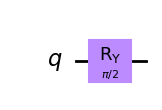

In [4]:
enc = encoder(0.5)

enc.draw('mpl')

It can be seen that corresponding to the value $0.5$, the qubit is rotated by an angle of $\frac{\pi}{2}$.

So encoding part is accomplished. On the contrary, the Memory register is left untouched as it carries the memory from the previous state (at time $t-1$). So at time $t$, we have the subset $n_B$ encoded with the data at time $t$ and the memory register carries the data from the previous time step ($t-1$). The composite system of $n_B + n_A$ qubits is now acted upon by an Ansatz, a Parmeterized Quantum Circuit which consists of random parameterized gates which alter the state of the composite system and the final state at time $t$ upon the state of the $n_B + n_A$ qubits after data encoding and the parameters controlling the Parameterized Quantum Circuit/Ansatz. The learning happens inside an Ansatz. The Ansatz first applies parameterized rotations to the qubits along all three directions (X, Y, and Z) and then, it entangles the qubits which develops the correlations between the subsets $n_B$ and $n_A$. 

Lets construct an Ansatz using qiskit's TwoLocal library.

In [5]:
from qiskit.circuit.library import TwoLocal

def ansatz(params):
    
    """For our case, since both the registers have 1 qubit, the Ansatz will have 2 qubits as it is applied on both the subsets.
    We choose to rotations to be along all 3 directions and then entangle them using the CZ (controlled Z) gates. The entangling
    scheme used here is all to all, i.e., full, which doesn't really matter in a circuit with just 2 qubits. This process is
    repeated many times to have the circuit depth as the complexity of the task demands."""
    pqc = TwoLocal(num_qubits = 2, rotation_blocks = ['rx', 'ry', 'rz'], entanglement_blocks = ['cz'], entanglement = 'full', reps = 3, skip_final_rotation_layer = True, insert_barriers = True)

    """Now, we bind the parameters of the Ansatz with real values before returning it."""
    pqc = pqc.bind_parameters(dict(zip(pqc.parameters, params)))
    pqc.name = 'Ansatz'

    return pqc

We get an Ansatz as follows.

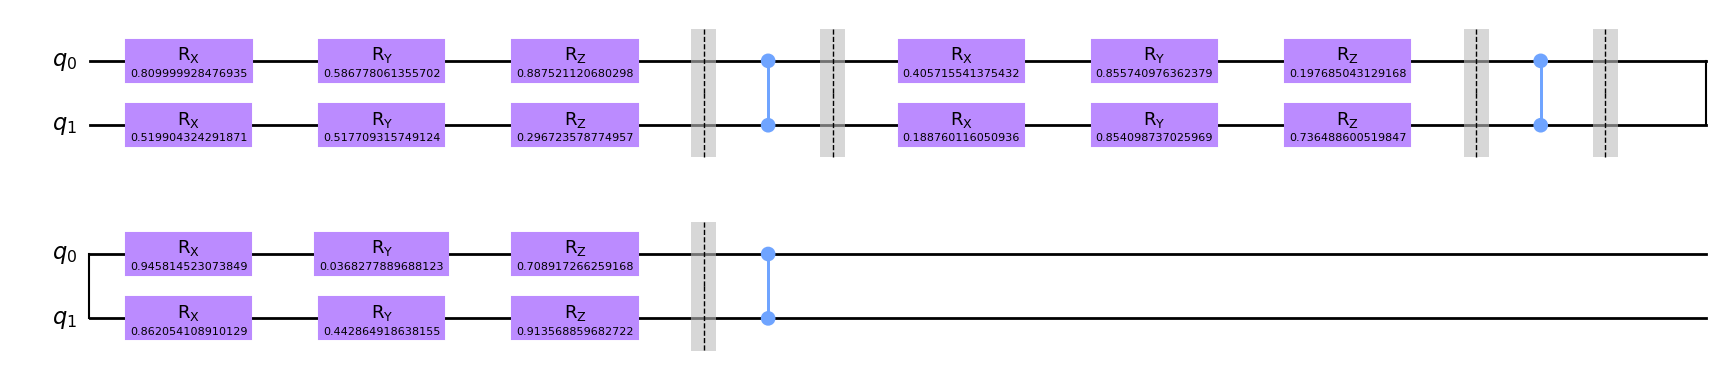

In [6]:
pqc = ansatz(np.random.rand(18))
pqc.decompose().draw('mpl')

All the learning happens in an Ansatz. The operations within the Ansatz can choose to forget the states from previous time steps and the entangling of qubits in the subsets $n_B$ and $n_A$ helps in updating the memory register with the new data recieved at the time step $t$. Afer Ansatz operation, the memory register is updated to $\rho_A^t$, ready to be fed to the next time step, $t+1$. But before that, we measure the subset $n_B$. Note that the qubits in the subset $n_B$ not only have the data at time $t$, but it also is manipulated by the entangling operations within the Ansatz. It develops correlations and the state of the qubits in subset $n_B$ are evolved depending upon the state of the memory register. So after the Ansatz operation, the qubits in the subset $n_B$ carry the state $\rho_B^t$, that we desire. So, we measure the expectation value of the desired observable O, (pauli Z operator in our case), or a set of observables ${O_i}$, and the output of the circuit at time $t$ is a function of linear combination of the expectation values of those observables.

After measurement, the qubits of the subset $n_B$ have to recieve the new data, so they are reinitialized with the state $|0\rangle$, the qubits in subset are left as they are (after Ansatz operation), and finally the system is ready to be fed to the same sequence of operations at the time $t+1$.

The schematic of the overall operation is descibed in the following figure (a).

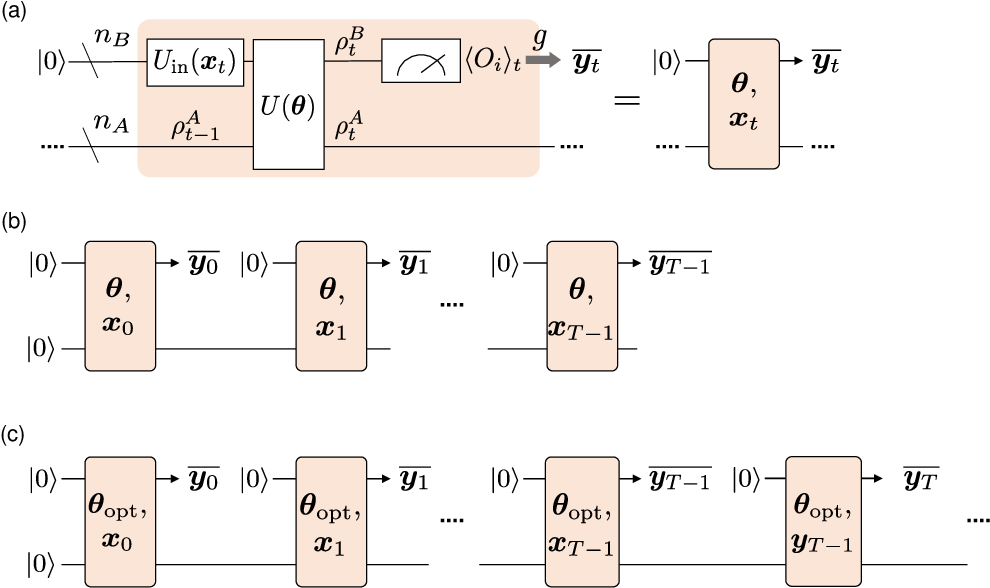


(b) shows the circuit in the measurement phase. The qubits in the subset $n_B$ are measured at each time step.

(c) shows the circuit measurement with optimized parameters.

Now, we need to write functions to measure the circuit at each time step and then to optimize the parameters.
First, let's see our circuit in action.

{'0': 505, '1': 495}


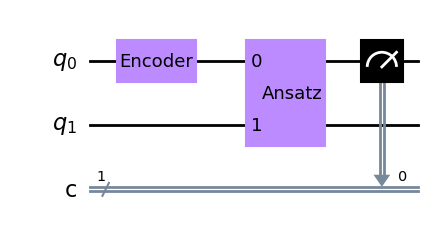

In [7]:
# Making a new circuit
qc = QuantumCircuit(2, 1) # Quantum Circuit with 2 qubits and 1 classical bit

# Adding encoder to the circuit
qc.append(encoder(0.5), [0]) # Appending encoder to the 0th qubit

# Making the ansatz
num_params = 18 # We know that we have 18 parameters for 3 repetitions. This process can be automated as per convenience. 
params = np.random.rand(num_params)
PQC = ansatz(params)

# Adding ansatz to the circuit
qc.append(PQC, [0,1]) # Appending ansatz to both the qubits

# Measuring the circuit
qc.measure(0, 0) # Measuring 0th qubit and storing the data in the classical bit
results = execute(qc, Aer.get_backend('qasm_simulator'), shots = 1000).result().get_counts() # Using Qasm Simulator as the backend

print(results)

qc.draw('mpl')

For the next step, we need to apply the same circuit after reinitializing the qubit 0.

{'1': 492, '0': 508}


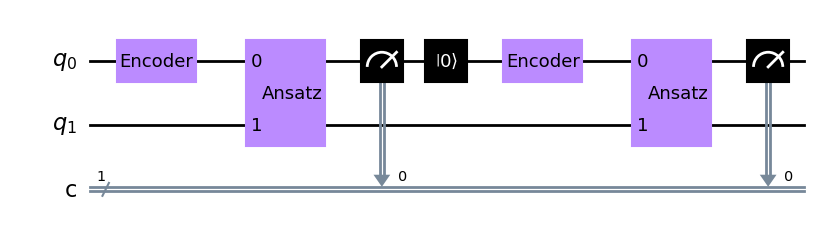

In [8]:
# Reinitializing the qubit 0.
qc.reset([0])

# Appending the encoder corresponding to new data.
qc.append(encoder(0.6), [0])

# Appending the Ansatz (ansatz remains the same for all the time steps).
qc.append(PQC, [0,1])

# Measuring the circuit.
qc.measure(0, 0) 
results = execute(qc, Aer.get_backend('qasm_simulator'), shots = 1000).result().get_counts()

print(results)

qc.draw('mpl')

Hence, we have a functional Quantum Recurrent Neural Network. Lets make a prediction function for the same.

In [9]:
import time

# We shall use sigmoid function to transform the output.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict(params):
    
    # Making a new Quantum Circuit
    qc = QuantumCircuit(2, 1)
    pred = []
    labels = []
    
    """The following loop measures the qubit 0 at each time step and appends the result to the list pred."""
    start = time.time()
    for i in range(len(dataset)):
        
        qc.append(encoder(dataset[i][0]), [0])
        qc.append(ansatz(params),[0,1])
        
        qc.measure(0, 0)
        
        results = execute(qc, Aer.get_backend('qasm_simulator'), shots = 1000).result().get_counts()
        
        if '1' not in results:
            results['1'] = 0
        
        pred.append(results['1']/1000)
        
        qc.reset([0])
        
        
        labels.append(dataset[i][0])
    stop = time.time()

    # print(stop-start)
        
    return pred[0:len(dataset)-1], labels[1:]

In [10]:
from IPython.display import clear_output
import tensorflow as tf


# Defining the cost function.
def Measurement_Based_Cost_Function(params):

    true_label, pred = predict(params)
    true_label = np.array(true_label).astype('float32')
    pred = np.array(pred).astype('float32')
    
    mse = tf.keras.losses.MeanSquaredError()
    loss = mse(true_label, pred).numpy()
    cost = loss
    
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    min_cost = min(objective_func_vals)
    print(f"The minimum loss after {len(objective_func_vals)} iterations is {min_cost}.")
    
    return cost

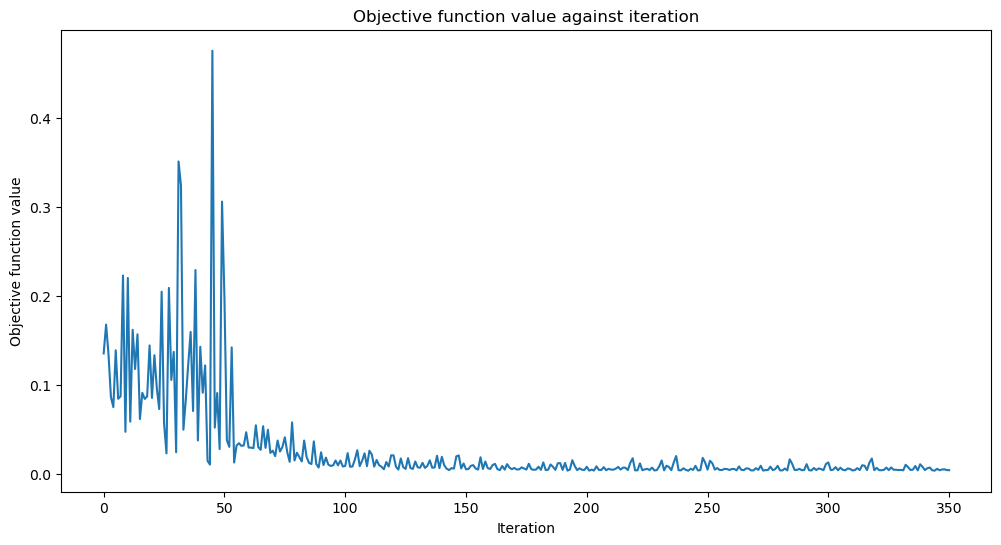

The minimum loss after 351 iterations is 0.0031820209696888924.
Optimized parameters are:

 [ 0.373151   -0.58403144  0.08903883  1.6910501   0.66232745  0.56067749
 -0.0500522  -0.69163285  0.0677197  -0.81279928  0.84637872  1.88604081
 -0.008571    2.40409242 -0.4018887  -1.16299694  2.02408428  1.87811559].
runtime is 14041.868174791336.


In [11]:
from qiskit.algorithms.optimizers import SPSA
import matplotlib.pyplot as plt

min_cost = 1.0
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback(num, params, cost, step_size, boo):
    
    if cost < min_cost:
        print(f"Best parameters = {params}, Min cost = {round(cost, 3)}")
        
    return None

start = time.time()
# Running the SPSA optimizer
spsa = SPSA(maxiter=100, callback = callback)
result = spsa.minimize(Measurement_Based_Cost_Function, x0 = np.random.rand(18), bounds = (0,1))
optimized_params = result.x
print(f"Optimized parameters are:\n\n {optimized_params}.")
stop = time.time()
duration = stop-start
print(f"runtime is {duration}.")

Now, we have the optimized parameters. We shall run it again to test whether it can replicate the training data.

In [12]:
predictions, labels = predict(optimized_params)

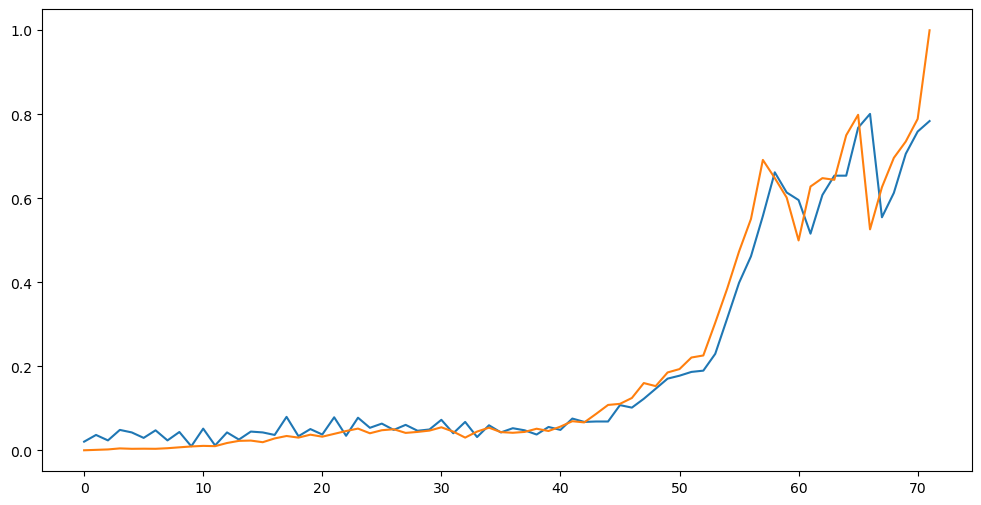

In [13]:
import matplotlib.pyplot as plt
iteration = np.arange(0,len(dataset)-1)
plt.plot(iteration, predictions)
plt.plot(iteration, labels)

It very well replicates the data and it should run well on the test data as well. The main problem however, is the runtime of the circuit on a classical machine. The circuit keeps getting deeper at each time step. This is the simplest example that we could consider and it takes hours to optimize even though the dataset is just around 70 data instances long. This problem however, won't be faced of a universal quantum computer. But the classical simulations show that it works.